# Simulation study on multinomial logit
This notebook is an example of Bayesian multinomial logit regression for subset choice modeling on synthetic data.

The multinomial logit (MNL) model assumes that for any offered set of items $B$ at most one alternative is chosen. As such, applying this model to subset-choice data in which two or more items are occasionally selected introduces a problem. In particular, if ever a choice of two or more items is observed, the likelihood is zero, and parameters become unlearnable via likelihood methods. To remedy this the data is coerced to fit the model, by sampling uniformly at random one "selected" label and setting the others to "not selected". This is statistically barbaric, but done in order togive MNL a chance at being used as a subset choice model. When the observed choices are made increasingly mutually exclusice, the influcence of our data manipulation diminishes, and we expect the performance of MNL to improve.

In [34]:
import simulation_tools as simu
import arviz as az
import scipy.stats as ss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
#from scipy.spatial import distance_matrix

In [35]:
# shortcuts
tfd = tfp.distributions
tfb = tfp.bijectors
dtype = tf.float64

# plotting settings
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

In [36]:
# experiment parameters
rng_u = np.random.default_rng(seed=26121991)
nItems = 15
nTrain = 500 # trials used for training
nTest = 500 # trials used for training
nTrials = nTrain + nTest # nr trials
nPoints = np.repeat(nItems, nTrials)  # points per tiral
minx, maxx = -2, 2 # box extent
radius = 2.7 # Matern thinning radius

## Generte synthetic data
See the notebook ``simu_logistic.ipynb`` for details - the same data is generated here.

In [37]:
# sample points
lons = [rng_u.uniform(minx, maxx, size=n) for n in nPoints] # X
lats = [rng_u.uniform(minx, maxx, size=n) for n in nPoints] # Y
points = [np.vstack([lons[i], lats[i]]).T for i in range(nTrials)] 

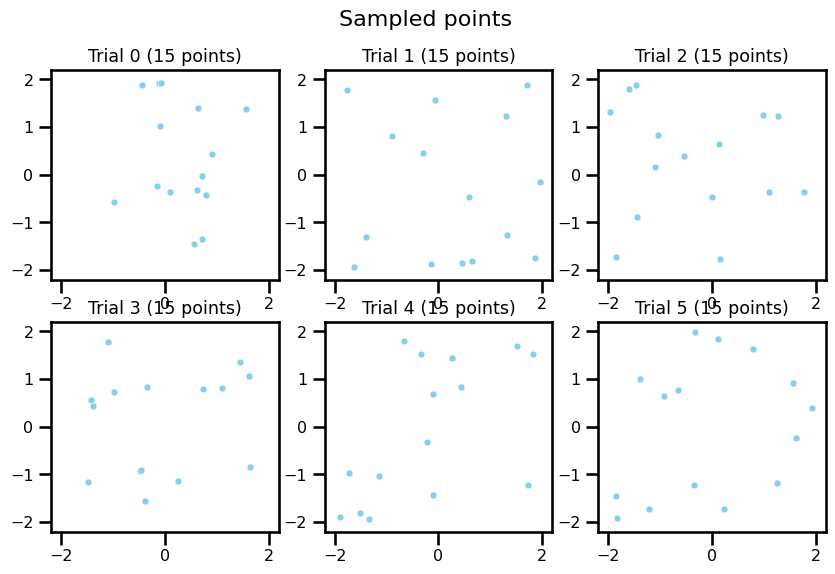

In [38]:
# make datasets
Xs = []
for i in range(nTrials):
    Xs.append(np.vstack((np.ones(nPoints[i]), np.sqrt(lons[i]**2 + lats[i]**2), lats[i], lons[i])).T)
Zs = []
for i in range(nTrials):
    Zs.append([distance_matrix(points[i], points[i])])

simu.plot_points(points, 0, title="Sampled points")

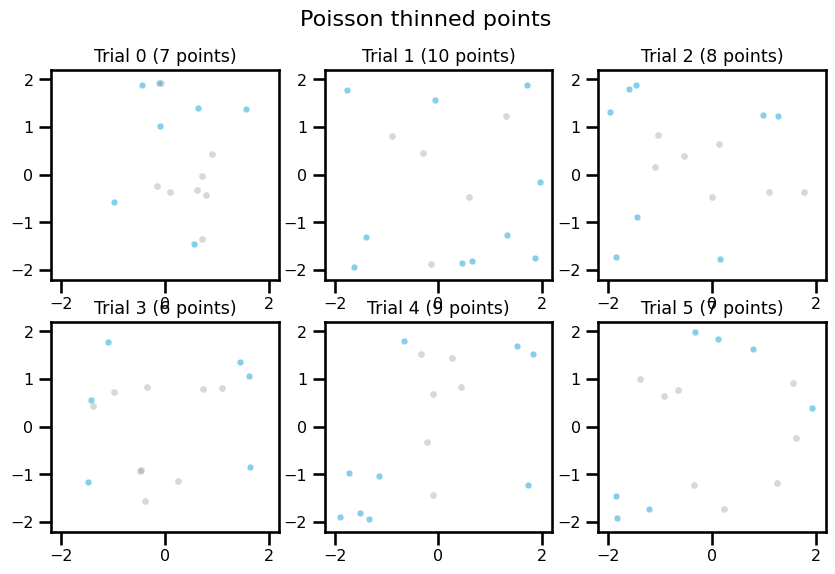

In [39]:
# poisson thinning
rng_t = np.random.default_rng(seed=18842524)
beta0 = -5.0
beta1 = 2.5

# thinned labels
labels = [np.ones(shape=n).astype(bool) for n in nPoints] # all labels are 1
probs = [np.exp(beta0 + X[:, 1]*beta1) for X in Xs]
unifs = [rng_t.uniform(0, 1, size=n) for n in nPoints] 
retain = [(unifs[i] < probs[i]) for i in range(nTrials)]
labels = [labels[i] * retain[i] for i in range(nTrials)]

simu.plot_points(points, 0.0, labels=labels, title="Poisson thinned points")

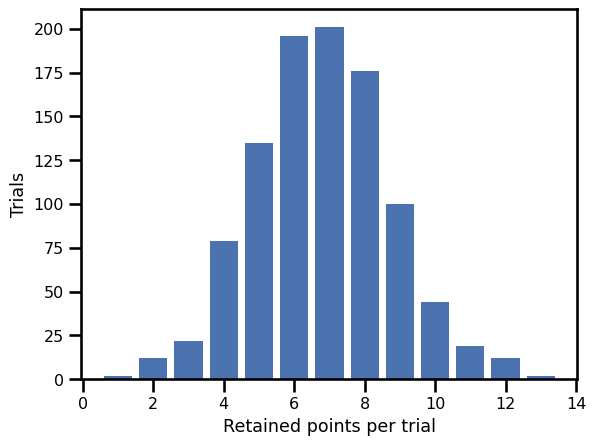

In [40]:
# histogram of nr points
n_pts = [label.sum() for label in labels]
unique, counts = np.unique(n_pts, return_counts=True)
plt.bar(unique, height=counts)
plt.xlabel("Retained points per trial")
plt.ylabel("Trials")
plt.show()

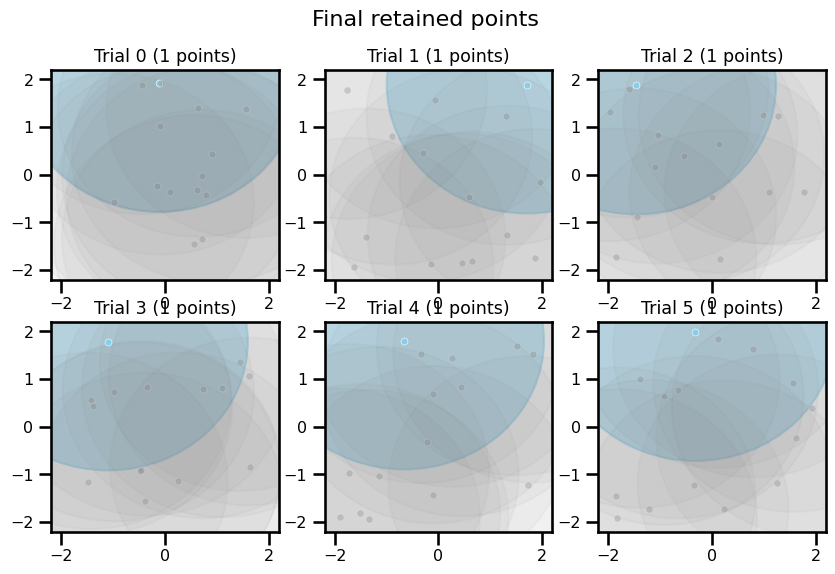

In [41]:
# sample matern
labels = [simu.sample_matern_iii(Xs[i][:, 2], Zs[i][0], radius, labels=labels[i]) for i in range(nTrials)]
simu.plot_points(points, radius, labels=labels, title="Final retained points")

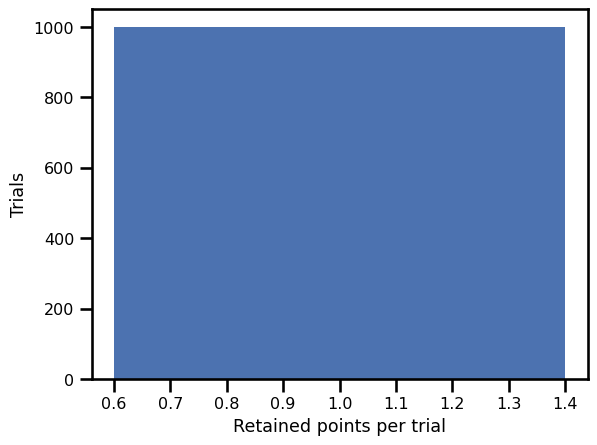

In [42]:
# histogram of nr points
n_pts = [label.sum() for label in labels]
unique, counts = np.unique(n_pts, return_counts=True)
plt.bar(unique, height=counts)
plt.xlabel("Retained points per trial")
plt.ylabel("Trials")
plt.show()

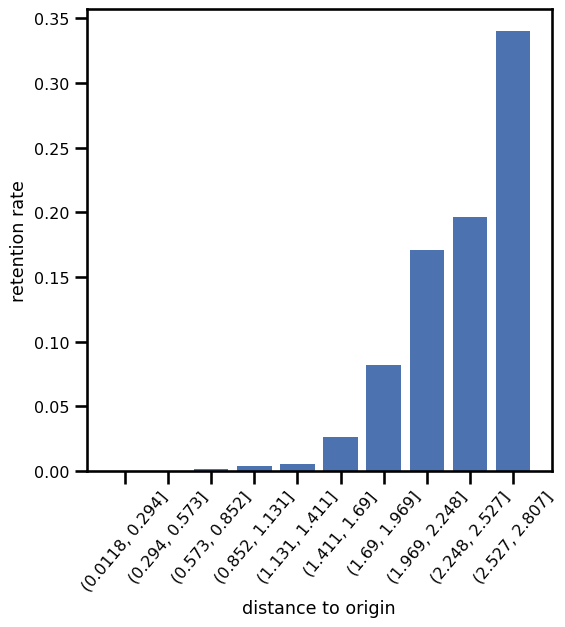

In [43]:
# plot x-bins vs percentage included
data = np.array([X[:, 1] for X in Xs]).flatten()
outs = np.array(labels).flatten()  # outcomes array
df = pd.DataFrame(data={'x':data, 'outcome':outs})
df['bin'] = pd.cut(df['x'], bins=10)

# make data
rows = df.groupby('bin')['outcome'].mean().index.astype(str).values
heights = df.groupby('bin')['outcome'].mean().values

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(x=rows, height=heights)
ax.set_ylabel('retention rate')
ax.set_xlabel('distance to origin')
plt.xticks(rotation=50);

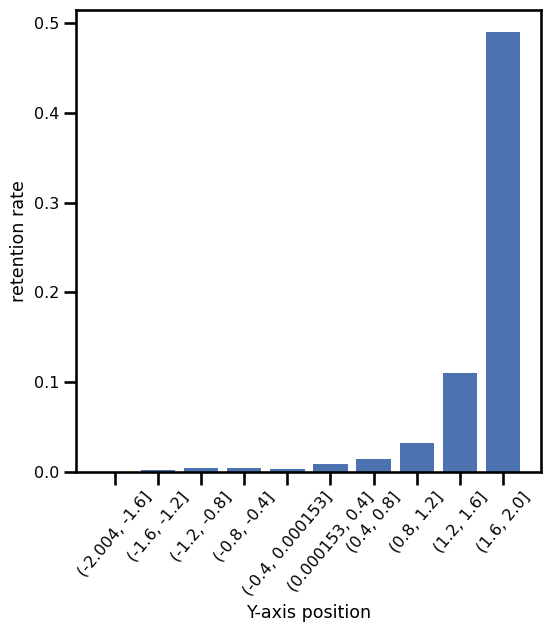

In [44]:
# plot x-bins vs percentage included
data = np.array([X[:, 2] for X in Xs]).flatten()
outs = np.array(labels).flatten()  # outcomes array
df = pd.DataFrame(data={'x':data, 'outcome':outs})
df['bin'] = pd.cut(df['x'], bins=10)

# make data
rows = df.groupby('bin')['outcome'].mean().index.astype(str).values
heights = df.groupby('bin')['outcome'].mean().values

fig, ax = plt.subplots(figsize=(6,6))
ax.bar(x=rows, height=heights)
ax.set_ylabel('retention rate')
ax.set_xlabel('Y-axis position')
plt.xticks(rotation=50);

## Bayesian multinomial logit regression

In [45]:
# numpy arrays
arr_Xs = np.array(Xs)
arr_Xs = arr_Xs[:, :, 1:]  # remove constant column
arr_labels = np.array(labels)

# number of obs per trial
n_obs = arr_labels.sum(axis=1)

In [46]:
# Split to testing and training data
X_train = arr_Xs[:nTrain, ...]
y_train = arr_labels[:nTrain, ...]

X_test = arr_Xs[nTrain:, ...]
y_test = arr_labels[nTrain:, ...]

print("There are %d training trials." % X_train.shape[0])
print("There are %d testing trials." % X_test.shape[0])
print(f"The training data X has shape {X_train.shape}.")
print(f"The training data y has shape {y_train.shape}.")

There are 500 training trials.
There are 500 testing trials.
The training data X has shape (500, 15, 3).
The training data y has shape (500, 15).


Next, we randomly subsable the training labels so that at most one items has a positive label in each trial.

In [47]:
# subsample at most one positive observation 
rng_train = np.random.default_rng(seed=6746245245)

for i in range(nTrain):
    if y_train[i].sum() > 1:
        # choose one of the True indices
        index = rng_train.choice(np.where(y_train[i])[0])
        new_y = np.repeat(False, nItems)
        new_y[index] = True
        y_train[i] = new_y
    elif y_train[i].sum() == 0:
        index = rng_train.choice(nItems)
        y_train[i][index] = True

print("Finished processing %d training trials." % nTrain)
print(f"All trials have at most one choice: {np.all(y_train.sum(axis=1) <= 1)}")

Finished processing 500 training trials.
All trials have at most one choice: True


In [48]:
# prepare the data
X_train = tf.constant(X_train, dtype=dtype) 
y_train = tf.constant(y_train, dtype=dtype)
X_test = tf.constant(X_test, dtype=dtype)
y_test = tf.constant(y_test, dtype=dtype)
print("There are %d training observations." % X_train.shape[0])
print("There are %d testing observations." % X_test.shape[0])

There are 500 training observations.
There are 500 testing observations.


## Make prior model

In [49]:
# generate prior
nDims = X_train.shape[-1]

# form a prior over beta0 and beta1
means_prior = np.zeros(nDims)
sigma_prior = 10

beta_prior = tfd.MultivariateNormalDiag(loc=means_prior,
                                        scale_diag=np.ones(nDims)*sigma_prior,
                                        name='beta_prior')

In [50]:
def make_clogit_logposterior(prior, X_train, y_train):
    """Functional closure for loglikelihood function."""
    
    def _logposterior(beta):
        """Compute linear response and evaluate."""
        return simu.clogit_log_prob(beta, X_train, y_train) + prior.log_prob(beta)
    
    return _logposterior

# get log posterior
log_posterior = make_clogit_logposterior(beta_prior, X_train, y_train)

In [51]:
# test function and gradient call
params = tf.constant([[1, 0, 0]], dtype=dtype)
[funval, grads] = tfp.math.value_and_gradient(log_posterior, params)
print("Function Value: ", funval)
print('Gradient: \n', grads)

Function Value:  tf.Tensor([-1133.27346485], shape=(1,), dtype=float64)
Gradient: 
 tf.Tensor([[164.90957985 830.11497322 -20.06397488]], shape=(1, 3), dtype=float64)


In [52]:
# Setup NUTS for Bayesian inference
nChains = 25
num_burnin = 100
num_results = 500

# generator for uniform points 
rng_p = np.random.default_rng(seed=3545412092)
initial_state = rng_p.uniform(2, 4, size=(nChains, nDims))

# define nuts kernel
nuts_kernel = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=log_posterior,
    step_size=np.float64(0.1)
    )

# nuts adaptive kernel
nuts_adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
    nuts_kernel,
    num_adaptation_steps=int(num_burnin * 0.8),
    step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
    step_size_getter_fn=lambda pkr: pkr.step_size,
    log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
    target_accept_prob=0.7
)

@tf.function
def run_chain(initial_state, num_results=5000, num_burnin_steps=0):
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=nuts_adaptive_kernel,
      trace_fn=lambda current_state, kernel_results: kernel_results)

In [53]:
# run chain & get results
samples, kernel_results = run_chain(initial_state, num_results, num_burnin)

In [54]:
# summaries
results = samples.numpy().T
data = az.convert_to_dataset({'beta1': results[0, :],
                              'beta2': results[1, :],
                              'beta3': results[2, :]}
                              )

# get log accept ratio
log_accept_ratio = kernel_results.inner_results.log_accept_ratio
p_accept = tf.math.exp(tfp.math.reduce_logmeanexp(tf.minimum(log_accept_ratio, 0.)))
print("Acceptance ratio: \t %.3f" % p_accept.numpy())

Acceptance ratio: 	 0.845


In [55]:
# effective sample size
print(az.ess(data)['beta1'].values)
print(az.ess(data)['beta2'].values)
print(az.ess(data)['beta3'].values)

6990.200911555817
6763.1394206154555
13345.863854631118


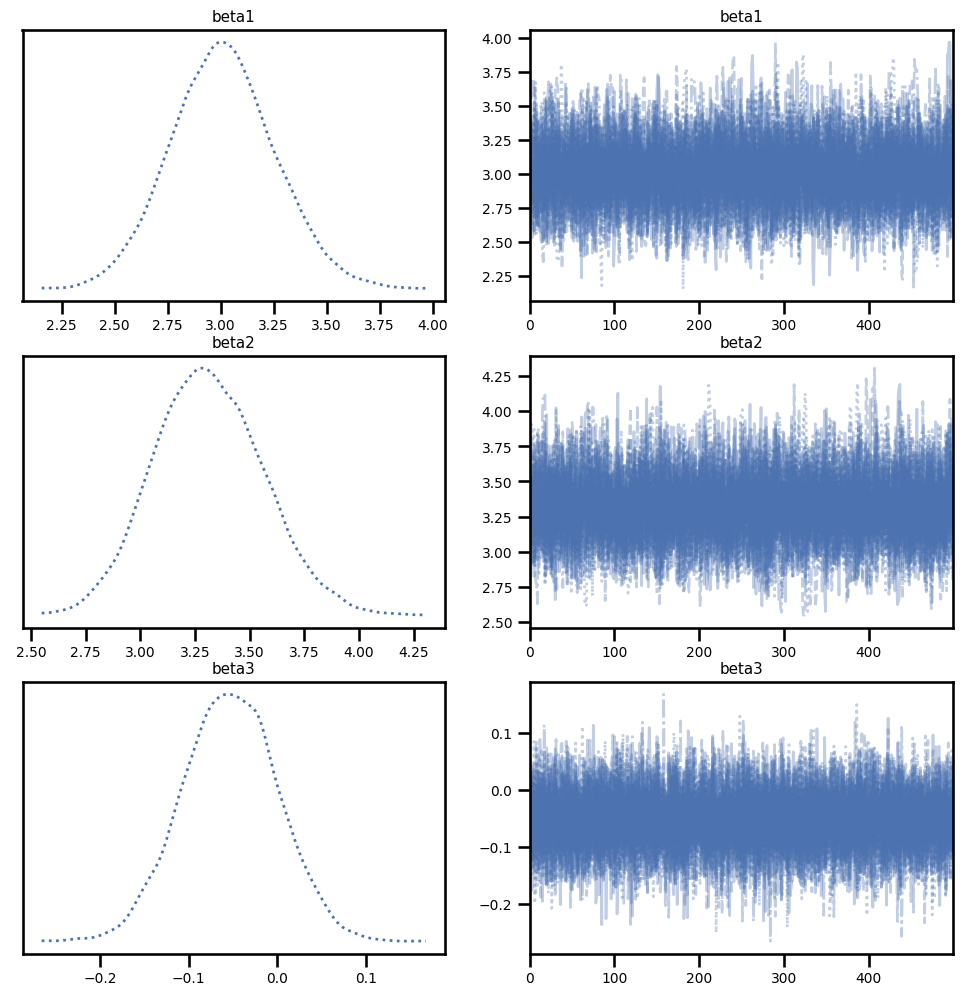

In [56]:
# trace plot
axes = az.plot_trace(data, combined=True, compact=True, figsize=(12, 12))
fig = axes.ravel()[0].figure
fig.savefig(f'plots/mnlogit/traceplot_{nItems}_{radius}.png')

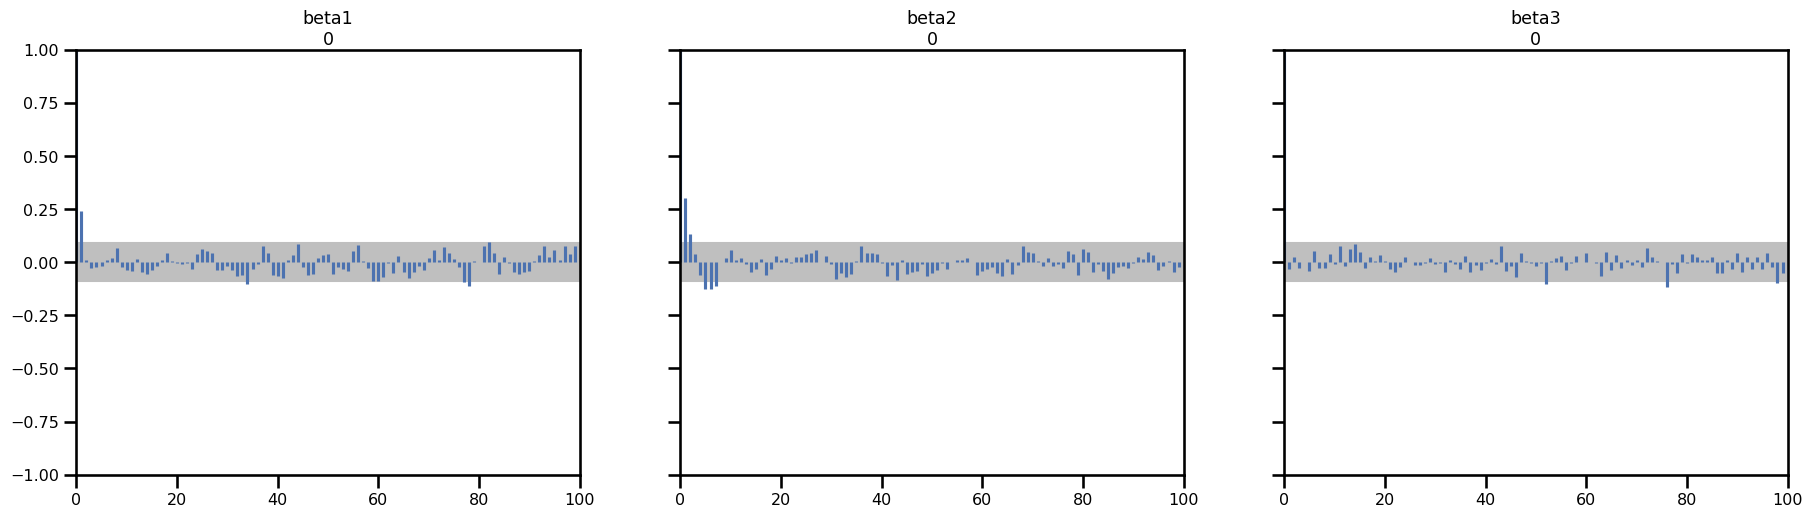

In [57]:
# autocorrelation plots
axes = az.plot_autocorr(data.sel(chain=[0]))
fig = axes.ravel()[0].figure
fig.savefig(f'plots/mnlogit/autrocorrelation_{nItems}_{radius}.png')
plt.show()

In [58]:
az.rhat(data) #.to_netcdf(f'data/mnlogit/rhat_{nItems}_{radius:.2f}.json')

<xarray.Dataset>
Dimensions:  ()
Data variables:
    beta1    float64 1.002
    beta2    float64 1.004
    beta3    float64 1.002

## Predictions

In [59]:
# collect betas
betas = samples[-1, :, :]

# make predictions
rng = np.random.default_rng(20122221201)
p_pred = simu.clogit_pred_prob(betas, X_test).numpy()

predictions = np.zeros(shape=p_pred.shape)
for chain in range(nChains):
    for trial in range(nTest):
        i = rng.choice(np.arange(int(nItems)), p=p_pred[chain, :, trial])
        predictions[chain, i, trial] = 1

# save predictions
folder = 'data/mnlogit/'
save_predictions = predictions.reshape(nChains, nItems * nTest) # reshape to 2D
np.savetxt(folder + f"pred_{nItems}_items_rad{radius:.1f}.csv", save_predictions, delimiter=",")

(25, 3)


## Results

In [60]:
# read from file
res = np.genfromtxt(folder + f"pred_{nItems}_items_rad{radius:.1f}.csv", delimiter=",", usemask=False)
print(res.shape)
res = res.reshape(nChains, nItems, nTest)
print(res.shape)

(25, 7500)
(25, 15, 500)


In [28]:
# sample predictions and evaluate
mcc, std = simu.summarize_mcc(res, y_test.numpy())

print(f"Mean MCC is {mcc:.2f} (SE {std:.4f})")

Mean MCC is 0.53 (SE 0.0231)
